In [1]:
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import dtwsom
from minisom import MiniSom
import pickle
from sklearn.cluster import KMeans

/home/kenan/.pyenv/versions/3.9.2/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
with open('daily_NO2.pkl', 'rb') as f:
    data_NO2_df = pickle.load(f)
dataNO2 =np.stack(data_NO2_df["NO2"])

In [3]:
with open('daily_O3.pkl', 'rb') as f:
    data_O3_df = pickle.load(f)
dataO3 =np.stack(data_O3_df["O3"])

In [4]:
with open('daily_all_pollutants.pkl', 'rb') as f:
    data_all_df = pickle.load(f)
data_all =np.array([np.stack(data_all_df["NO2"]), np.stack(data_all_df["O3"]), np.stack(data_all_df["PM25"]), np.stack(data_all_df["PM10"])])

In [5]:
data_all_new = np.swapaxes(data_all, 0, 1)

In [6]:
som = dtwsom.MultiDtwSom(10, 10, data_all_new.shape[2], bands =data_all_new.shape[1], w = [0.25, 0.25, 0.25, 0.25], sigma=1, learning_rate=0.5, random_seed=10,gl_const="sakoe_chiba", scr=60)
som.pca_weights_init(data_all_new)
som.train_batch(data_all_new, 2000, verbose=True)
weights = som.get_weights()

 [ 2000 / 2000 ] 100% - 4.75 it/s - 0:00:00 left  - quantization error: 49108.823068778605


In [7]:
KMeans_X = np.stack((np.array(weights)[0]+np.array(weights)[1]+np.array(weights)[2]+np.array(weights)[3]).reshape(100, 24))
KMeans_all = KMeans(n_clusters=4, random_state=0).fit(KMeans_X)
KMeans_all.labels_

array([3, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 3, 2, 0, 0, 2, 3,
       2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 2, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

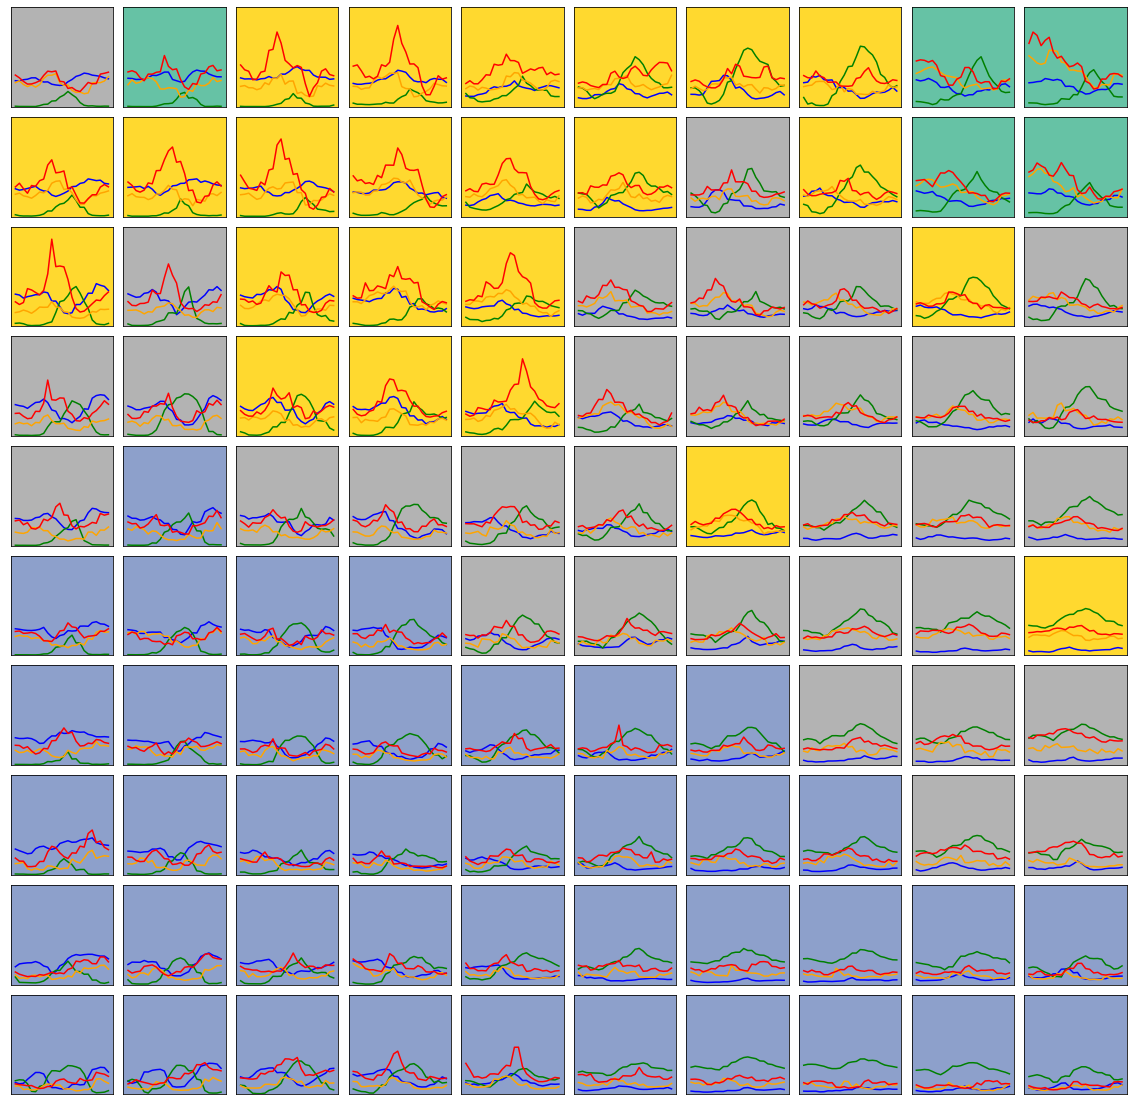

In [11]:
plt.figure(figsize=(20, 20))
norm = matplotlib.colors.Normalize(vmin=0, vmax=3, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Set2)
for i in range(10):
    maxylim= np.max(data_all)
    for j in range(10):
        ax = plt.subplot(10, 10, i*10 + 1+j)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_ylim((0,maxylim/5))
        plt.plot(np.array(weights)[0, i, j, :], color= 'blue')
        plt.plot(np.array(weights)[1, i, j, :], color= 'green')
        plt.plot(np.array(weights)[2, i, j, :], color= 'orange')
        plt.plot(np.array(weights)[3, i, j, :], color= 'red')
        ax.set_facecolor(mapper.to_rgba(KMeans_all.labels_[i*10 +j]))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [9]:
test = som.labels_map(data_all_new,data_all_df.site)

In [12]:
test.keys()

dict_keys([(7, 2), (8, 0), (9, 9), (9, 0), (5, 5), (5, 1), (6, 1), (3, 6), (7, 5), (8, 4), (6, 5), (5, 6), (3, 4), (9, 4), (4, 5), (6, 4), (7, 6), (8, 5), (7, 8), (4, 9), (6, 9), (1, 6), (4, 6), (3, 8), (0, 6), (4, 4), (3, 9), (1, 7), (4, 7), (2, 8), (0, 7), (5, 7), (0, 5), (0, 9), (1, 8), (9, 2), (5, 4), (5, 3), (2, 0), (3, 2), (7, 3), (9, 1), (8, 9), (7, 9), (4, 3), (0, 4), (6, 6), (1, 5), (7, 0), (7, 1), (6, 0), (1, 0), (0, 0), (8, 8), (2, 3), (7, 4), (6, 7), (9, 7), (6, 3), (2, 5), (9, 6), (8, 6), (3, 3), (1, 9), (8, 2), (3, 5), (0, 2), (5, 0), (4, 0), (4, 1), (8, 3), (9, 8), (6, 2), (5, 2), (8, 1), (3, 1), (3, 7), (3, 0), (4, 2), (2, 2), (1, 2), (5, 9), (6, 8), (2, 1), (2, 4), (1, 4), (2, 7), (0, 8), (9, 3), (0, 1), (8, 7), (2, 9), (7, 7), (1, 1), (2, 6), (0, 3), (1, 3), (9, 5), (5, 8), (4, 8)])

In [10]:
test_q = som.quantization(data_all_new)

In [12]:
test_qe = som.quantization_error(data_all_new)

In [13]:
test_qe

50083.29136646947

In [14]:
dataNO2 =np.stack(data_NO2_df["NO2"])
somNO2 = dtwsom.DtwSom(10, 10, dataNO2.shape[1], sigma=1, learning_rate=0.5, random_seed=10, gl_const="sakoe_chiba", scr=60)
somNO2.pca_weights_init(dataNO2)
somNO2.train_batch(dataNO2, 200, verbose=True)
weightsNO2 = somNO2.get_weights()

 [ 200 / 200 ] 100% - 18.33 it/s - 0:00:00 left  - quantization error: 18.373171610290292


In [16]:
test_qe2 = somNO2.quantization_error(dataNO2)

In [18]:
test_qe2

18.373171610290292

In [11]:
test2 = somNO2.labels_map(dataNO2,data_NO2_df.site)

In [13]:
test2.keys()

dict_keys([(8, 6), (4, 0), (6, 1), (4, 1), (6, 2), (5, 0), (7, 2), (9, 2), (9, 0), (5, 2), (6, 3), (9, 3), (8, 1), (9, 5), (3, 0), (9, 4), (8, 3), (9, 1), (8, 2), (5, 5), (6, 4), (4, 2), (5, 4), (8, 0), (3, 1), (5, 3), (2, 1), (7, 1), (3, 2), (4, 5), (5, 1), (6, 5), (3, 3), (7, 3), (6, 6), (7, 0), (8, 5), (6, 0), (4, 3), (8, 4), (7, 6), (7, 5), (7, 4), (4, 4), (3, 4), (5, 6), (2, 0), (9, 6), (3, 5), (2, 2), (2, 4), (2, 3), (4, 6), (7, 7), (1, 2), (8, 7), (1, 1), (6, 7), (1, 3), (1, 0), (2, 5), (9, 7), (5, 7), (3, 6), (1, 4), (4, 7), (0, 1)])

In [22]:
data_all_new.shape

(3623, 4, 24)

In [ ]:
dataNO2.shape

In [8]:
test_df = data_all_df[data_all_df.site=='037-0016']
data_test_old = np.array([np.stack(test_df["NO2"]), np.stack(test_df["O3"]), np.stack(test_df["PM25"]), np.stack(test_df["PM10"])])
data_test = np.swapaxes(data_test_old, 0, 1)

som.activation_response(data_test)
        

array([[  0.,   0.,   0.,   0.,   0.,   0., 418.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [17]:
from tslearn.metrics import dtw
activation_map = np.zeros((10, 10))
weights = np.random.RandomState().rand(10, 10, 24)*2-1
weights /= np.linalg.norm(weights, axis=-1, keepdims=True)
def activate(x):
    """Updates matrix activation_map, in this matrix
       the element i,j is the response of the neuron i,j to x."""
    # s = subtract(x, self._weights)  # x - w
    it = np.nditer(activation_map, flags=['multi_index'])
    while not it.finished:
        # || x - w ||
        for i in range(4):
            activation_map[it.multi_index] += 0.25*dtw(x[i], weights[i][it.multi_index],
                                                                   )
            it.iternext()
def winner(x):
    """Computes the coordinates of the winning neuron for the sample x."""
    activate(x)
    return np.unravel_index(activation_map.argmin(),
                         activation_map.shape)

In [30]:
activation_map.argmin()

99

In [33]:
for i in range(len(data_all_new)):
    activate(data[i])
    
    print(activation_map.argmin(), np.unravel_index(activation_map.argmin(),
                         activation_map.shape))

4 (0, 4)
4 (0, 4)
4 (0, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
14 (1, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)
4 (0, 4)


In [15]:
winner(data_test[1])

NameError: name 'data_test' is not defined

In [21]:
activation_map.shape

(10, 10)